# Regression in Fully Connected Networks using *Variance Back-Propagation*

This notebook provides a demo for performing inference in BNNs using an FCN model, for the method of *Variance Back-Propagation* from [Haussmann et al. (2019)](https://arxiv.org/abs/1805.07654).

## GPU support

This block is to disable GPU execution of TensorFlow. Depending on your system, enabling GPU may result in faster training.

*Comment this block to enable GPU execution*

In [1]:
# Disable GPU execution
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Packages

We import some standard packages as wel as TensorFlow and our own Bayesian TensorFlow package, make sure you have them installed prior!

In [2]:
# Import packages
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import bayesian_tensorflow as btf

## Setup

Below we set the experiment details for the demo, mostly concerning the specific dataset and the number of training epochs.

We use a seed for reproducibility, but this can be ignored if preferred by setting it to `None`.

In [3]:
# Set hyperparameters
name     = 'boston'
n_epochs =  750
seed     =  60

Based on the dataset we set the batch-size, which we do below.

In [4]:
# Get proper batch-size
if name in ['boston', 'energy', 'yacht']: 
    batch_size = 16
elif name in ['concrete', 'wine']: 
    batch_size = 32
else: # i.e. [kin8nm, naval, powerplant]
    batch_size = 64

## Dataset

We have inlcuded the UCI datasets used in our paper, which we have stored in the `dataset` folder.

You can load a specific dataset using the function `uci.load` and specifying the name of the dataset.

In [5]:
# Get datasets module
from datasets import uci

# Load dataset
(x, y) = uci.load(name=name, seed=seed)

We save the total number of data samples, as this is needed in the computation of the VFE loss.

In [6]:
# Total data size
n_data = tf.cast(tf.shape(x)[0], dtype=tf.float32)

We then set our seed for randomness, combine the data samples into a TensorFlow dataset and shuffle it.

In [7]:
# Set random seed
tf.random.set_seed(seed)

# Create TF-dataset
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=len(x)).batch(batch_size)

## Model

We start with a normalization layer to normalize the input data.

In [8]:
# Normalizer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x))

Depending on the dataset, we have either one or two output nodes.

In [9]:
# Output layer units, to update with dataset
O = 2 if (name == 'energy' or name == 'naval') else 1

We now create the model using the `Sequential` model from TensorFlow, with our custom layers.

We need to specify which layer is the input layer in order to generate the input variance in that layer, we do this with the `is_input` flag.

We also need to indicate which layer is the output layer, since by default the VBP layer uses a ReLU activation. This is done with the `is_output` flag.

In [10]:
# Create model
model = tf.keras.models.Sequential([
    normalizer,
    btf.layers.DenseVBP(50, is_input=True, seed=seed),
    btf.layers.DenseVBP(O, is_output=True, seed=seed),
    btf.layers.GammaVBP(O),
])

__*You always need to add a Gamma layer to the end of the model!*__

This layers adds the gamma parameters into the model and allows for joint optimization.

In [11]:
# Overview of model
model.summary(line_length=75, positions=[0.55, 0.85, 1.0, 1.0])

Model: "sequential"
___________________________________________________________________________
 Layer (type)                            Output Shape          Param #     
 normalization (Normalization)           (None, 13)            27          
                                                                           
 dense_vbp (DenseVBP)                    (None, 50, 2)         1400        
                                                                           
 dense_vbp_1 (DenseVBP)                  (None, 1, 2)          102         
                                                                           
 gamma_vbp (GammaVBP)                    (None, 1, 4)          2           
                                                                           
Total params: 1,531
Trainable params: 1,504
Non-trainable params: 27
___________________________________________________________________________


## Training

We save the three separate terms of the VFE loss for evaluation of the training process.

In [12]:
# Variables to store training results
vfe_kl_theta = np.zeros(n_epochs)
vfe_kl_tau   = np.zeros(n_epochs)
vfe_acc_loss = np.zeros(n_epochs)

We use the `Adam` optimizer for the training and set the learning rate accordingly.

In [13]:
# Set correct learning rate
lr = 1e-3 if (name in ['naval']) else 1e-2

# Create optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

We use a custom training loop with a progress bar for the training process.

The custom update step is included in `btf.inference.VBP`, which performs VFE minimization on mini-batches.

It also returns the three separate terms of the VFE loss.

In [14]:
# Custom training loop
for epoch in tqdm(range(n_epochs), desc='Training'):    
    
    # Iterate over training batches
    for x_batch, y_batch in dataset:
        
        # Perform training step
        kl_theta, kl_tau, acc_loss = \
            btf.inference.VBP(model, optim, x_batch, y_batch, n_data)
            
        # Add losses to total
        vfe_kl_theta[epoch] += kl_theta
        vfe_kl_tau[epoch]   += kl_tau
        vfe_acc_loss[epoch] += acc_loss

Training:   0%|          | 0/750 [00:00<?, ?it/s]

## Saving

We save the weights of the trained model for use in further experiments.

In [15]:
# Set save directory
save_dir = './models/VBP/' + name + '/weights'

# Save entire model
model.save_weights(save_dir)

## Evaluation

We can evaluate the VFE after training.

In order the have reproducible results, we reset the dataset.

In [16]:
# Reset dataset
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.batch(batch_size)

We now evaluate the model for the whole dataset.

In [17]:
# Variables to store result
vfe_total = 0
    
# Iterate over data batches
for x_batch, y_batch in dataset:

    # Add VFE loss to total
    vfe_total += btf.evaluation.VBP(model, x_batch, y_batch, n_data)
    
# Show final Variational Free Energy
print('Free Energy: ' + f'{vfe_total:.0f}')

Free Energy: 1597


## Plots

Finally, we can plot the total VFE loss and its separate terms for the training duration.

This function is placed into a seperate folder of `figures`.

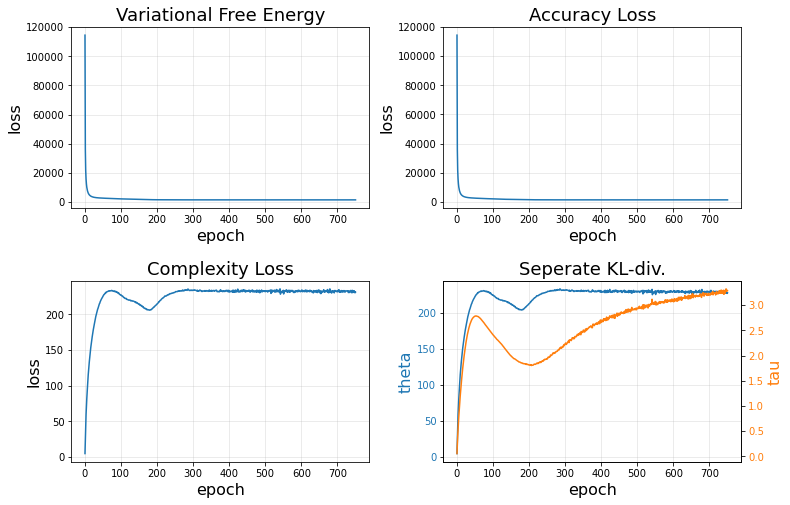

In [18]:
# Import local module
from figures import PlotTrainingLosses

# Plot training losses
PlotTrainingLosses(vfe_kl_theta, vfe_kl_tau, vfe_acc_loss)

## Post-hoc BMR

Compression using BMR is implemented for each layer. By default, the variance of the reduced prior is set to $10^{-16}$.

You can call the compression method for each custom layer, using the `compress()` method.

In [19]:
# First dense layer, second layer of the model
model.layers[1].compress()
# Second dense layer, third layer of the model
model.layers[2].compress()

We can now revaluate the VFE to see the effect of post-hoc BMR.

In [20]:
# Variables to store result
vfe_total = 0
    
# Iterate over data batches
for x_batch, y_batch in dataset:

    # Add VFE loss to total
    vfe_total += btf.evaluation.VBP(model, x_batch, y_batch, n_data)
    
# Show final Variational Free Energy
print('Free Energy: ' + f'{vfe_total:.0f}')

Free Energy: 1471
